In [1]:
# 库导入

from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

In [2]:
# 全局变量声明

clusterNum = []
dest = 0
src = 0

### 初级要求

In [3]:
# singleLinkage&completeLinkage函数实现

MAX_NUM = 1e3

def singleLinkage(X):
    modify = []
    for i in range(len(X[0])):
        modify.append(min(X[0][i],X[1][i]))
    return modify
    
def completeLinkage(X):
    modify = []
    for i in range(len(X[0])):
        modify.append(max(X[0][i],X[1][i]))
    return modify

### 中级要求

In [4]:
# averageLinkage函数实现

def averageLinkage(X):
    modify = []
    for i in range(len(X[0])):
        modify.append((clusterNum[dest]*X[0][i]+clusterNum[src]*X[1][i])/(clusterNum[dest]+clusterNum[src]))
    return modify

In [5]:
# AgglomerativeClustering类定义

class AgglomerativeClustering:
    def __init__(self):
        # 对每次的合并进行记录
        self.steps=[]

    def fit(self,datas,method):
        # averageLinkage需要以下几个变量
        global clusterNum
        global dest
        global src
        
        self.dataCnt = datas.shape[0]
        
        # 预处理各点之间的距离
        allDist = np.zeros((self.dataCnt,self.dataCnt))
        for i in range(self.dataCnt):
            for j in range(i):
                allDist[i][j] = allDist[j][i] = np.sum((datas[i]-datas[j])**2)
        setList, clusterCount = [[i] for i in range(self.dataCnt)], self.dataCnt
        print("calculate distance finish!")

        # 聚类间距离矩阵
        clusterDist = np.zeros((self.dataCnt,self.dataCnt))+MAX_NUM
        clusterNum = np.zeros(2000)
        
        for i in range(clusterCount):
            clusterNum[i]=1
            for j in range(i+1,clusterCount):
                clusterDist[i][j] = clusterDist[j][i] = allDist[i][j]
        print("calculate cluster distance finish!")

        while clusterCount != 1:
            # 最相似的两个聚类
            res = np.argmin(clusterDist)
            dest,src = int(res/clusterCount),res%clusterCount
            # steps进行一次记录
            self.steps.append((setList[dest][0],setList[src][0]))
            # 聚类间距离矩阵更新
            modify = method(clusterDist[[dest,src]])
            clusterDist[dest] = modify
            clusterDist[:,dest] = modify
            clusterDist = np.delete(clusterDist,src,axis=0)
            clusterDist = np.delete(clusterDist,src,axis=1)
            clusterDist[dest][dest] = MAX_NUM
            # averageLinkage权重数组更新
            clusterNum[dest] += clusterNum[src]
            clusterNum = np.delete(clusterNum,src)
            # 聚类更新
            setList[dest] = setList[dest] + setList[src]
            del setList[src]
            clusterCount -= 1
            #if (self.dataCnt - clusterCount) % (self.dataCnt / 20) == 0:
                #print(clusterCount, " clusters left.")

        print("cluster finish !")

    def label(self,k):
        root = list(range(self.dataCnt))
        def find_root(n):
            if root[root[n]] == root[n]:
                return root[n]
            root[n]=find_root(root[n])
            return root[n]
        for i in range(self.dataCnt-k): # 根据steps记录产生非连通图
            src,dest = self.steps[i]
            root[find_root(dest)] = find_root(src)
        cluster, clusterNum = [0 for i in range(self.dataCnt)], 0
        for i in range(self.dataCnt): # 将根节点标注为新的cluster
            if i == root[i]: # i是根
                clusterNum += 1
                cluster[i] = clusterNum
        for i in range(self.dataCnt): # 将非根节点标注为根节点的cluster
            if i != root[i]: # i不是根
                cluster[i] = cluster[find_root(i)]
        return cluster

In [6]:
#生成数据

def create_data(centers,num=100,std=0.7):
    '''
    生成用于聚类的数据集
    :param centers: 聚类的中心点组成的数组。如果中心点是二维的，则产生的每个样本都是二维的。
    :param num: 样本数
    :param std: 每个簇中样本的标准差
    :return: 用于聚类的数据集。是一个元组，第一个元素为样本集，第二个元素为样本集的真实簇分类标记
    '''
    X, labels_true = make_blobs(n_samples=num, centers=centers, cluster_std=std)
    return  X,labels_true

In [7]:
#可视化聚类结果

def plot_data(*data):
    '''
    绘制用于聚类的数据集
    :param data: 可变参数。它是一个元组。元组元素依次为：第一个元素为样本集，第二个元素为样本集的真实簇分类标记，第三个元素为预测分类标记
    :return: None
    '''
    X,labels_true,labels_predict,cnt=data
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    colors='rgbyckm'
    markers='o^sP*DX'
    for i in range(len(labels_true)):
        predict=labels_predict[i]
        ax.scatter(X[i,0],X[i,1],label="cluster %d"%labels_true[i],
        color=colors[predict%len(colors)],marker=markers[labels_true[i]%len(markers)],alpha=0.5)

In [8]:
#生成数据

centers=[[1,1,1],[1,3,3],[3,6,5],[2,6,8]]
X,labels_true= create_data(centers,2000,0.5)
np.savetxt('data.dat',X)
np.savetxt('label.dat',labels_true)
print("generate data finish!")

generate data finish!


calculate distance finish!
calculate cluster distance finish!
cluster finish !
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
-------Segmentation-------


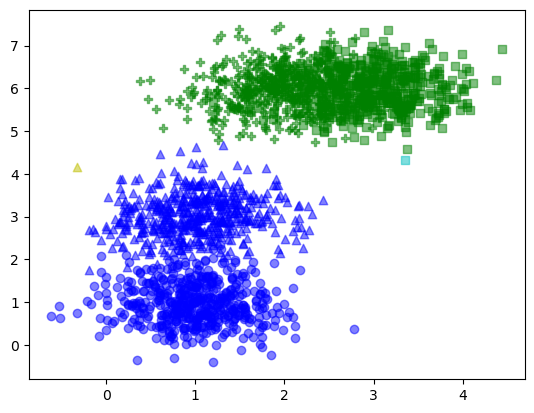

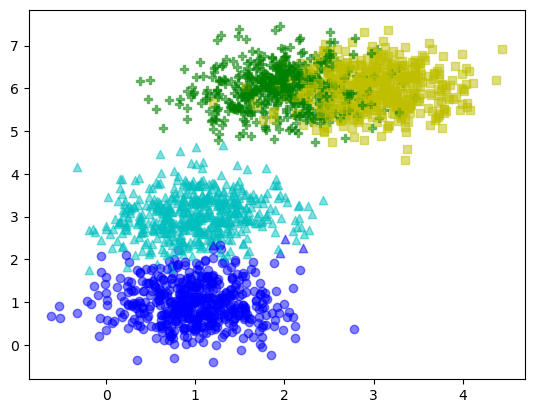

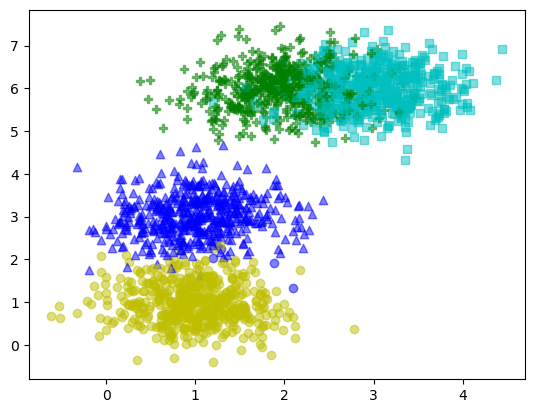

In [9]:
#调用不同聚类方法

METHOD_APPLY = [singleLinkage,completeLinkage,averageLinkage]

cnt=0
for method in METHOD_APPLY:
    model = AgglomerativeClustering()
    model.fit(X,method)
    k=4
    plot_data(X,labels_true,model.label(k),cnt)
    cnt+=1
    print("-------Segmentation-------")

我们可以从上述聚类结果中看出，在k=4时，`completeLinkage`和`averageLinkage`的性能要优于`singleLinkage`.其原因在于,由于`singleLinkage`采用的距离指标是集合之间最小的距离,所以对于距离较近的簇无法进行有效的区分

### 高级要求

calculate distance finish!
calculate cluster distance finish!
cluster finish !
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
-------Segmentation-------


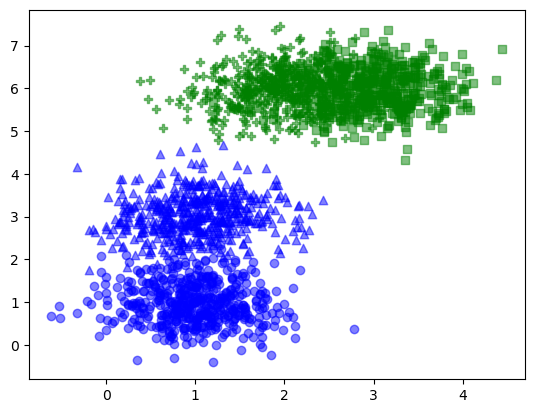

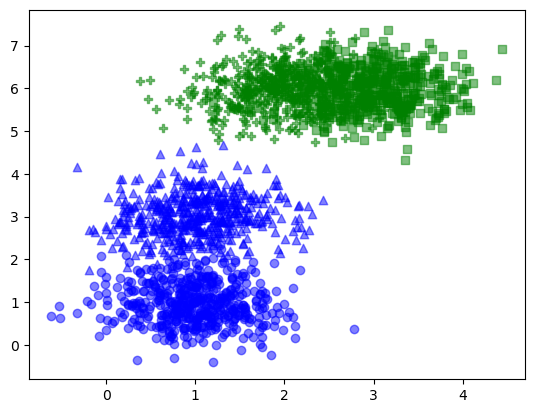

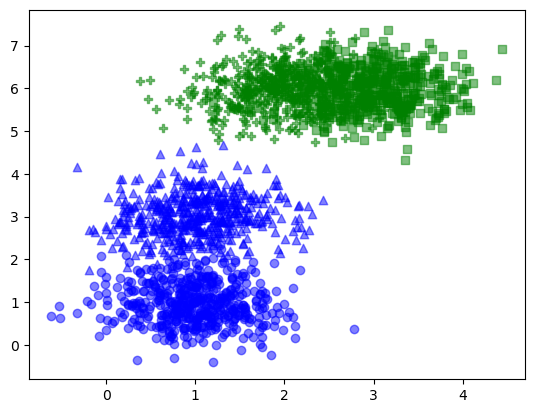

In [10]:
cnt=0
for method in METHOD_APPLY:
    model = AgglomerativeClustering()
    model.fit(X,method)
    k=2
    plot_data(X,labels_true,model.label(k),cnt)
    cnt+=1
    print("-------Segmentation-------")

k=2时,三种算法性能相近

calculate distance finish!
calculate cluster distance finish!
cluster finish !
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
-------Segmentation-------


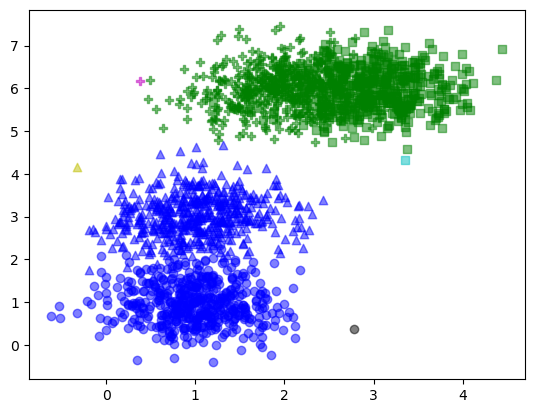

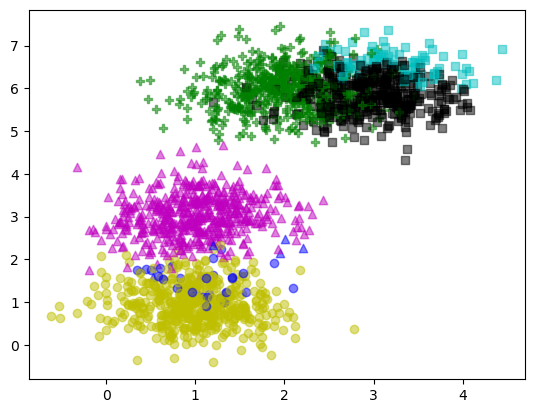

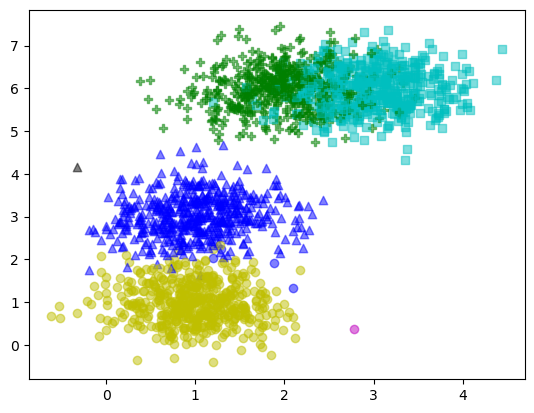

In [11]:
cnt=0
for method in METHOD_APPLY:
    model = AgglomerativeClustering()
    model.fit(X,method)
    k=6
    plot_data(X,labels_true,model.label(k),cnt)
    cnt+=1
    print("-------Segmentation-------")

可以看出,当k=6时,`averageLinkage`的性能要优于`singleLinkage`和`completeLinkage`.`completeLinkage`产生了本不存在的类,`singleLinkage`还是会将两个距离较近的簇聚成一个类

总结:
- 聚类个数小于实际类别时,三种算法性能相近
- 聚类个数等于实际类别时,`averageLinkage`和`completeLinkage`性能较好
- 聚类个数大于实际个数时,`averageLinkage`性能较好